In [1]:
import os
import time
import copy
import glob
import cv2
import shutil

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
data_path = 'catanddog/train'

transform = transforms.Compose([
    transforms.Resize([256,256]),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    ])
train_dataset = torchvision.datasets.ImageFolder(data_path, transform = transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, num_workers = 8, shuffle = True)

print(len(train_dataset))

385


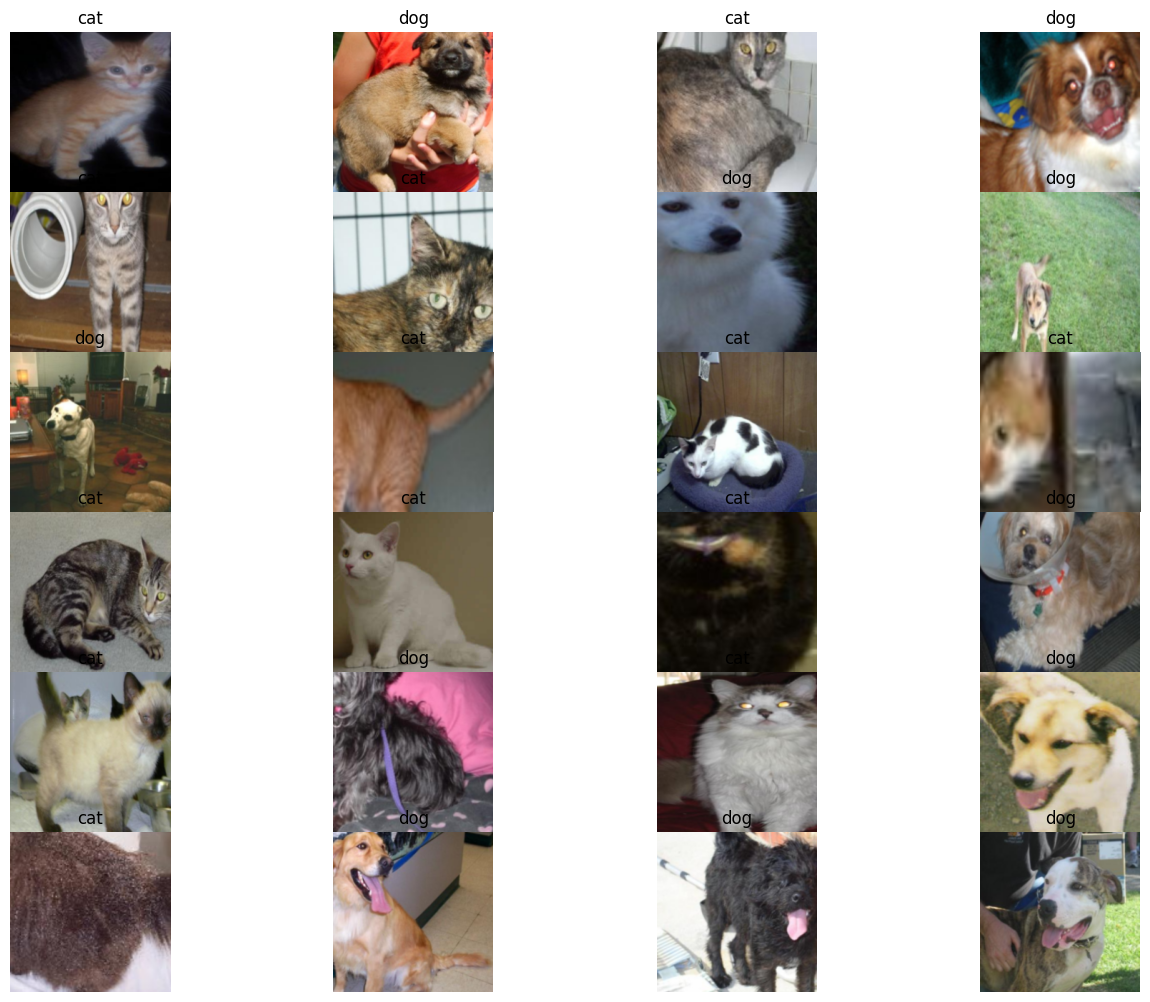

In [3]:
import numpy as np
samples, labels = next(iter(train_loader))
classes = {0 : 'cat', 1 : 'dog'}
fig = plt.figure(figsize=(16, 24))

for i in range(24):
    a = fig.add_subplot(6, 4, i + 1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))

plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [4]:
resnet18 = models.resnet18(pretrained=True)

c:\Users\cryju\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\cryju\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

set_parameter_requires_grad(resnet18)

In [6]:
resnet18.fc = nn.Linear(512, 2)

In [7]:
for name, param in resnet18.named_parameters():
    if param.requires_grad:
        print(name, param.data)

fc.weight tensor([[ 0.0004,  0.0373,  0.0109,  ..., -0.0237,  0.0114, -0.0324],
        [-0.0312,  0.0143,  0.0065,  ...,  0.0316, -0.0309,  0.0115]])
fc.bias tensor([ 0.0276, -0.0282])


In [8]:
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(512, 2)
for param in model.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=13, is_train=True):
    since = time.time()
    acc_history = []
    loss_history = []
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            model.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc
        
        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)
        torch.save(model.state_dict(), os.path.join('catanddog/', '{0:0=2d}.pth'.format(epoch)))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
    return acc_history, loss_history


In [10]:
params_to_update = []
for name, param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t", name)

optimizer = optim.Adam(params_to_update)

	 fc.weight
	 fc.bias


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
train_acc_hist,train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer, device)

Epoch 0/12
----------
Loss: 0.5705 Acc: 0.7117

Epoch 1/12
----------
Loss: 0.3697 Acc: 0.8779

Epoch 2/12
----------
Loss: 0.3325 Acc: 0.8416

Epoch 3/12
----------
Loss: 0.2606 Acc: 0.9169

Epoch 4/12
----------
Loss: 0.2145 Acc: 0.9247

Epoch 5/12
----------
Loss: 0.2646 Acc: 0.8961

Epoch 6/12
----------
Loss: 0.2524 Acc: 0.8805

Epoch 7/12
----------
Loss: 0.2922 Acc: 0.8649

Epoch 8/12
----------
Loss: 0.3133 Acc: 0.8468

Epoch 9/12
----------
Loss: 0.2593 Acc: 0.8805

Epoch 10/12
----------
Loss: 0.2611 Acc: 0.8727

Epoch 11/12
----------
Loss: 0.2095 Acc: 0.9143

Epoch 12/12
----------
Loss: 0.2297 Acc: 0.8909

Training complete in 1m 39s
Best Acc: 0.924675


In [12]:
test_path = 'catanddog/test/'

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor()
    ])
test_dataset = torchvision.datasets.ImageFolder(root=test_path, transform = transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, num_workers = 1, shuffle = True)

print(len(test_dataset))

98


In [13]:
def eval_model(model, dataloaders, device):
    since = time.time()
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob('catanddog/' + '*.pth')
    saved_models.sort()
    print('saved_model', saved_models)

    for model_path in saved_models:
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)

            _, preds = torch.max(outputs.data, 1)
            preds[preds >= 0.5] = 1
            preds[preds < 0.5] = 0
            running_corrects += preds.eq(labels).int().sum()

        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print('Acc: {:.4f}'.format(epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc
        
        acc_history.append(epoch_acc.item())
        print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
    return acc_history


In [14]:
val_acc_hist = eval_model(resnet18, test_loader, device)

saved_model ['catanddog\\00.pth', 'catanddog\\01.pth', 'catanddog\\02.pth', 'catanddog\\03.pth', 'catanddog\\04.pth', 'catanddog\\05.pth', 'catanddog\\06.pth', 'catanddog\\07.pth', 'catanddog\\08.pth', 'catanddog\\09.pth', 'catanddog\\10.pth', 'catanddog\\11.pth', 'catanddog\\12.pth']
Loading model catanddog\00.pth
Acc: 0.7959

Loading model catanddog\01.pth
Acc: 0.9286

Loading model catanddog\02.pth
Acc: 0.9388

Loading model catanddog\03.pth
Acc: 0.9388

Loading model catanddog\04.pth
Acc: 0.9490

Loading model catanddog\05.pth
Acc: 0.9388

Loading model catanddog\06.pth
Acc: 0.9490

Loading model catanddog\07.pth
Acc: 0.9388

Loading model catanddog\08.pth
Acc: 0.9184

Loading model catanddog\09.pth
Acc: 0.9388

Loading model catanddog\10.pth
Acc: 0.9184

Loading model catanddog\11.pth
Acc: 0.9388

Loading model catanddog\12.pth
Acc: 0.9184

Validation complete in 0m 53s
Best Acc: 0.948980


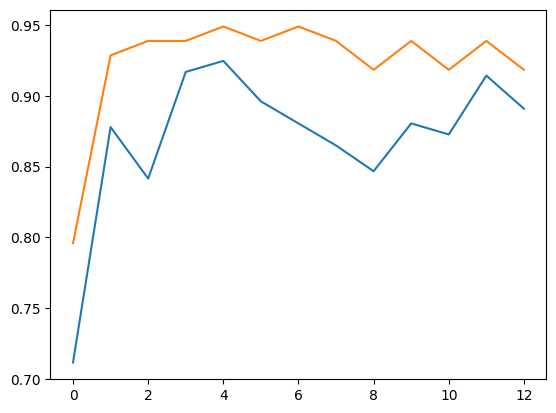

In [15]:
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

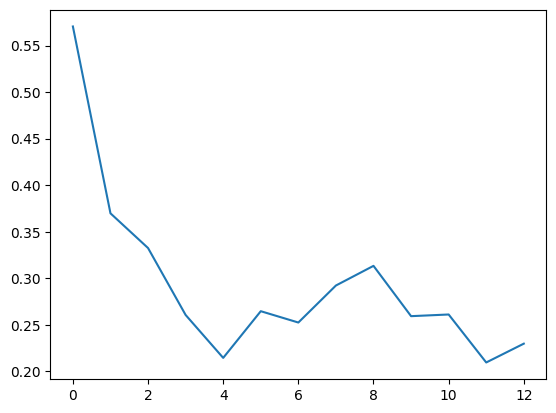

In [16]:
plt.plot(train_loss_hist)
plt.show()